# msprime_T2_distribution

This notebook will look at the pdf, cdf and iCR of different histories to see if we can match their observed distrubitions with analytical. This notebook supersedes msprime_T2_times.

The distributions it measures are:<br>f, which denotes pdf, which is P(T_2 = t), <br>F, which denotes CDF, which is P(T_2 <= t) and <br>iCR, which is the inverse coalescent rate, which is P(T_2 >t)/P(T_2=t)

## Setup

First import all modules and parse args (written when I was running through command line).

In [1]:
# import dependencies
import os
from datetime import datetime
import argparse
from msprime_models import * 
# from abinitio_tm import scaled_time_intervals
# from msprime_utils import scaled_time_intervals, get_het, round_coal_times, tm_counts, get_coal_data, round_bin_coal_data, normalise
from msprime_utils import *
from vcf_mhs import *
import numpy as np
import pdb
import math
import pandas as pd
from scipy.stats import entropy
import argparse
import matplotlib.pyplot as plt
import numpy as np

# pecify the paramaters you want. Defaults as below

parser = argparse.ArgumentParser()
parser.add_argument("model",help="Specify the model to be used, as defined in msprime_models.")
parser.add_argument("-N","--N_0",help="Initial population size (Default is 1e+04",default=1e+04,type=int)
parser.add_argument("-L","--seq_length",help="Length of the sequence to be simulated (default 3e+07)",default=int(3e+07),type=int)
parser.add_argument("-mig","--migration_prop",help="Proportion of migrating population (default 0.3)",default=0.3,type=float)
parser.add_argument("-t","--time_splits",nargs=2,help="Time of splits, in generations (default t_1 = 2e+04, t_2 = 4e+04)",default = [int(2e+04),int(4e+04)])
parser.add_argument("-bin","--bin_length",help="The length (in bases) of the how wide you want each bin. (Default is 100)",default=100,type=int)
parser.add_argument("-o_coaldir","--output_coaldir",help="Output directory of coalescent data",default=os.getcwd() + '/coal_data/',type=str)
parser.add_argument("-o_coalname","--output_coalname",help="Output name for coal_data filename",default='',type=str)
parser.add_argument("-o_mhsdir","--output_mhsdir",help="Output dir for vcf and mhs data",default=os.getcwd() + '/vcf_mhs/',type=str)
parser.add_argument("-o_mhsname","--output_mhsname",help="Output name for vcf and mhs data",default = '',type=str)
parser.add_argument("-rho","--recomb_rate",help="Rate of recombination per bp per generation",default=2e-08,type=float)
parser.add_argument("-mew","--mut_rate",help="Rate of mutation per bp per generation",default=2e-08,type=float)
parser.add_argument("--suffix_time",help="Boolean, whether to write the time in to the files (useful for multi runs of the same simulation",action="store_true")
parser.add_argument("--print",help="Print the DemographicDebugger (from msprime) and the number of segratating sites",action="store_true")
parser.add_argument("--tree",help="Draw trees and info per segment",action="store_true")


# TODO: maybe move this function to msprime_utils.py?
def get_counts_freq(sim,time_intervals,args):
    # this function returns the observed pdf of T2 (f_T2(t))

    # get true coalescent data
    tmrca_data = get_coal_data(sim, args) 

    # round this data into segments of size args.bin_length 
    coal_times = round_bin_coal_data(sim.sequence_length,tmrca_data, args) # partition coalescent data into bins  


    # round coalescence time into interval
    coal_times_intervals = np.array(round_coal_times(coal_times,time_intervals,N_T=len(time_intervals))) # round binned coalescent times into their respected interval

    # count number of occurunces in each interval
    counts = num_occcurences(coal_times_intervals,time_intervals)

    # get frequency of these (divide by sum). This is the pdf (=f_T2(t))
    counts_freq = counts / counts.sum()
    print('counts.sum() is {}'.format(counts.sum()))
    return counts_freq, counts.sum()

## Time Intervals and Scaling

We need to define time intervals for which we can either plot the expected (analytical distribution of T2) or measure the empirical (observed distribution of T2). For the analytical distributions, we need to scale each datapoint by a number to match the empirical. This is because the number of observed events depends on the parameters of the time intervals.

Note/TODO: Still can't really work out this scaling, it is some function of bin_length, seq_length and scaling (length of time_intervals is dependent on scaling), but there is something else in there and I don't know what it is. 

Leaving spacing as 1000, min_time and max_time as 0 and 3e+05 respectively, seq_length as 150e+06 and scaling =250*len(time_intervals)*(args.bin_length/seq_length) works well.

In [3]:
args = parser.parse_args("const_mig0003".split())
seq_length = 150e+06

# time intervals 
min_time = 0
max_time = 3e+05
spacing = 1000
time_intervals = np.arange(min_time,max_time,spacing)

# scaling
scaling = 250*len(time_intervals)*(args.bin_length/seq_length)
print(f'scaling is {scaling}')

scaling is 0.05


## Constant population size

Define a model. This one is simply a population of constant size with no growth or migration.

In [4]:
def constsize01(seq_length):
    N_0 = 1e+04
    
    population_configurations = [
        msprime.PopulationConfiguration(
            sample_size=2, initial_size=N_A0, growth_rate=0),
    ]
    demographic_events = []
    # Use the demography debugger to print out the demographic history
    # that we have just described.
    dd = msprime.DemographyDebugger(
        population_configurations=population_configurations,demographic_events=demographic_events)
    print('Demographic history:\n')
    dd.print_history()
    sim = msprime.simulate(population_configurations=population_configurations,
                           demographic_events=demographic_events, length=seq_length, recombination_rate=2e-08,
                           mutation_rate=2e-08)
    return sim


Run the simulation, choose a sequence length

In [5]:
seq_length = 150e+06

print("Running simulation")
sim1 = constsize01(seq_length)
print("Simulation sim_mig finished")


Running simulation
Demographic history:

Model =  hudson(reference_size=1)
Epoch: 0 -- inf generations
     start     end      growth_rate |     0    
   -------- --------       -------- | -------- 
0 |  1e+04    1e+04               0 |     0    

Simulation sim_mig finished


Now we can calculate the empirical (observed) distribution for the pdf, CDF and iCR. Note, for the iCR we have to multiply everything by the spacing of the time intervals.

(note this code will work for any simulation)

counts.sum() is 1500000.0


/home/trevor/miniconda3/envs/ancestry/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in double_scalars
  This is separate from the ipykernel package so we can avoid doing imports until


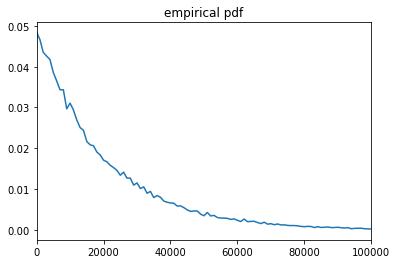

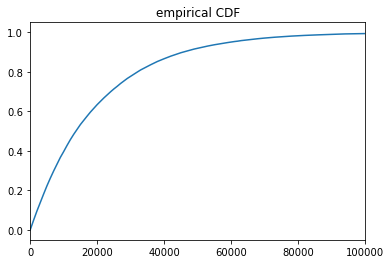

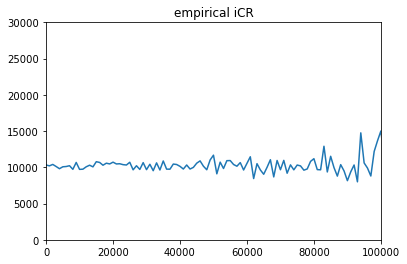

In [22]:
f_obs,counts_sum = get_counts_freq(sim1,time_intervals,args) # empirical pdf for non panmictic history, with constant structure and constant size
F_obs = [sum(f_obs[0:t]) for t in range(len(f_obs))] # this returns the CDF of T2 ( F_T2(t) )
iCR_obs = [spacing*(1-F_obs[i])/(2*f_obs[i]) for i in range(len(f_obs)) ] # this returns the CR of the history, defined as (1-F_T2(t))/f_T2(t)

plot_ = True
if plot_:
    plt.plot(time_intervals,f_obs)
    plt.xlim(0,100000)
    plt.title('empirical pdf')
    plt.show()

    plt.plot(time_intervals,F_obs)
    plt.xlim(0,100000)
    plt.title('empirical CDF')
    plt.show()

    plt.plot(time_intervals,iCR_obs)
    plt.xlim(0,100000)
    plt.ylim(0,30000)
    plt.title('empirical iCR')
    plt.show()


Now we can match these analytically. Note that so far this situation is just Kingmans coalescent with constant population size

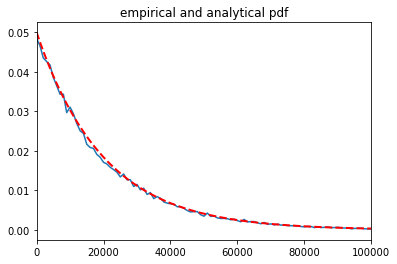

0.05


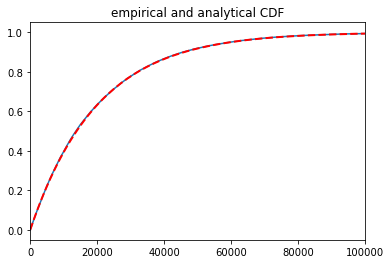

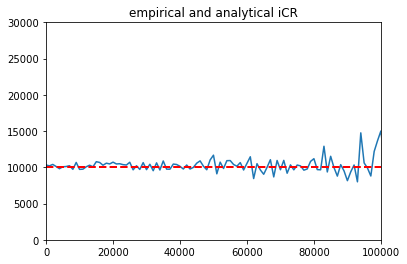

In [24]:
def f(x,N_0):
    x = x/(2*N_0) # we scale into continuous time (if T = gens we use t = T/2N)
    f = np.exp(-x)*scaling
    return f

N_0 = 1e+04 # as per the simuled model
plt.plot(time_intervals,f_obs)
plt.plot(time_intervals,f(time_intervals,N_0),color = "red",linestyle="dashed",linewidth=2)
plt.xlim(0,100000)
plt.title('empirical and analytical pdf')
plt.show()
print(scaling)

def F(x,N_0):
    x = x/(2*N_0)
    F = 1 - np.exp(-x)
    return F

def iCR(x,N_0):
#     x = x/(2*N_0)
    iCR = (1-F(x,N_0))/(2*f(x,N_0))*spacing # need to multiply by spacing to get iCR
    return iCR

plt.plot(time_intervals,F_obs)
plt.plot(time_intervals,F(time_intervals,N_0),color = "red",linestyle="dashed",linewidth=2)
plt.title('empirical and analytical CDF')
plt.xlim(0,100000)
plt.show()

plt.plot(time_intervals,CR_obs)
plt.plot(time_intervals,iCR(time_intervals,N_0),color = "red",linestyle="dashed",linewidth=2)
plt.xlim(0,100000)
plt.ylim(0,30000)
plt.title('empirical and analytical iCR')
plt.show()


In [26]:
del f, F, iCR, f_obs, F_obs, iCR_obs

## Population increase

Define a model. This one is a population that increases by amount gamma immediately at time T1 with no growth or migration.

In [32]:
def sizechange01(change,T_1,seq_length):
    N_0 = 1e+04
    population_configurations = [
        msprime.PopulationConfiguration(
            sample_size=2, initial_size=N_0, growth_rate=0),
    ]
    demographic_events = [
        msprime.PopulationParametersChange(time=T_1, initial_size=N_0*change)
    ]
    # Use the demography debugger to print out the demographic history
    # that we have just described.
    dd = msprime.DemographyDebugger(
        population_configurations=population_configurations,demographic_events=demographic_events)
    print('Demographic history:\n')
    dd.print_history()
    sim = msprime.simulate(population_configurations=population_configurations,
                           demographic_events=demographic_events, length=seq_length, recombination_rate=2e-08,
                           mutation_rate=2e-08)
    return sim


Run the simulation, choose a sequence length, relative change parameter and time to change.

In [ ]:
seq_length = 150e+06
change = 2
T_1 = 20000

print("Running simulation")
sim2 = sizechange01(change,T_1,seq_length)
print("Simulation finished")


Running simulation
Demographic history:

Model =  hudson(reference_size=1)
Epoch: 0 -- 20000.0 generations
     start     end      growth_rate |     0    
   -------- --------       -------- | -------- 
0 |  1e+04    1e+04               0 |     0    

Events @ generation 20000.0
   - Population parameter change for -1: initial_size -> 20000.0 
Epoch: 20000.0 -- inf generations
     start     end      growth_rate |     0    
   -------- --------       -------- | -------- 
0 |  2e+04    2e+04               0 |     0    



In [ ]:
f_obs,counts_sum = get_counts_freq(sim2,time_intervals,args) # empirical pdf for non panmictic history, with constant structure and constant size
F_obs = [sum(f_obs[0:t]) for t in range(len(f_obs))] # this returns the CDF of T2 ( F_T2(t) )
iCR_obs = [spacing*(1-F_obs[i])/(2*f_obs[i]) for i in range(len(f_obs)) ] # this returns the CR of the history, defined as (1-F_T2(t))/f_T2(t)

plot_ = True
if plot_:
    plt.plot(time_intervals,f_obs)
    plt.xlim(0,100000)
    plt.title('empirical pdf')
    plt.show()

    plt.plot(time_intervals,F_obs)
    plt.xlim(0,100000)
    plt.title('empirical CDF')
    plt.show()

    plt.plot(time_intervals,iCR_obs)
    plt.xlim(0,100000)
    plt.ylim(0,30000)
    plt.title('empirical iCR')
    plt.show()
